In [1]:
from abc import ABC
import numpy as np
import pandas as pd
import random
import os
import time

from functools import lru_cache
from path import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.modules.loss as L
import torch.nn.functional as F

from haversine import haversine, haversine_vector, Unit


# dtype = torch.float32
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# # device = torch.device("cpu")

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
import plotly

from tqdm import tqdm, trange

from dataset import TrackDataset as TrackDatasetCurvature, TrajectoryDataset

In [3]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10', 'traffic']


In [4]:
plt.style.use('seaborn-whitegrid')
# plt.rcParams['font.size'] = None

In [5]:
from dl_model_v6_dynamic_seq import *

model = load_model(r'model/v6_dynamic_seq_10_40/CONVO-GRU-model-server2.013_22_10.pt')
model.eval()

TpDeepModel(
  (encoder): Encoder(
    (feature): Sequential(
      (0): Conv1d(3, 16, kernel_size=(3,), stride=(1,))
      (1): ReLU()
      (2): Flatten()
      (3): Linear(in_features=128, out_features=32, bias=True)
      (4): ReLU()
    )
  )
  (decoder): Decoder(
    (gru): GRU(48, 32, batch_first=True)
    (fc_out): Linear(in_features=80, out_features=3, bias=True)
  )
)

In [6]:
class Stat:
    total_error = np.zeros(OUTPUT_SEQ_LEN)
    total_error_mape = np.zeros(OUTPUT_SEQ_LEN)
    total_count = np.zeros(OUTPUT_SEQ_LEN)
    
    total_error_phase1 = np.zeros(OUTPUT_SEQ_LEN)
    total_error_phase1_mape = np.zeros(OUTPUT_SEQ_LEN)
    total_count_phase1 = np.zeros(OUTPUT_SEQ_LEN)
    
    total_error_phase2 = np.zeros(OUTPUT_SEQ_LEN)
    total_error_phase2_mape = np.zeros(OUTPUT_SEQ_LEN)
    total_count_phase2 = np.zeros(OUTPUT_SEQ_LEN)
    
    total_error_phase3 = np.zeros(OUTPUT_SEQ_LEN)
    total_error_phase3_mape = np.zeros(OUTPUT_SEQ_LEN)
    total_count_phase3 = np.zeros(OUTPUT_SEQ_LEN)
    
    total_error_phase4 = np.zeros(OUTPUT_SEQ_LEN)
    total_error_phase4_mape = np.zeros(OUTPUT_SEQ_LEN)
    total_count_phase4 = np.zeros(OUTPUT_SEQ_LEN)
    
    all_errors = []

In [7]:
def compute_loss(output, true_loc, n_seq, phases=None, flight_id=None):
    mse = lambda v: (v**2).sum(axis=1)
    mse2d = lambda v1, v2: mse(v1 - v2)
    pred_loc, velo_diff = output

    n_total = n_seq.sum()
    replacement_loss = torch.tensor([0.], device=pred_loc.device)
    velo_loss = torch.tensor([0.], device=pred_loc.device)
    phases = phases.cpu().detach().numpy()
    for i, n in enumerate(n_seq):
        phase = phases[i]
        
        rel_er = pred_loc[i, :n, :2] - true_loc[i, :n, :2]
        
        t = rel_er.cpu().detach().numpy()
#         t[n:, :] = 0
        Stat.all_errors.append(dict(
            pred_loc=pred_loc[i, :, :].cpu().detach().numpy(), 
            true_loc=true_loc[i, :, :].cpu().detach().numpy(), 
            length=n,
            phase=phase,
            fid=flight_id,
        ))
        
        rel_er = rel_er[:n, :]
        er = mse(rel_er)
        
        replacement_loss += er.sum()
        Stat.total_error[:n] += er.cpu().detach().numpy()
        Stat.total_error_mape[:n] += np.sqrt(er.cpu().detach().numpy())
        Stat.total_count[:n] += 1
        # velo_loss += mse(velo_diff[i, :n, :])
        
        if phase == 1: 
            Stat.total_error_phase1[:n] += er.cpu().detach().numpy()
            Stat.total_error_phase1_mape[:n] += np.sqrt(er.cpu().detach().numpy())
            Stat.total_count_phase1[:n] += 1
        elif phase == 2: 
            Stat.total_error_phase2[:n] += er.cpu().detach().numpy()
            Stat.total_error_phase2_mape[:n] += np.sqrt(er.cpu().detach().numpy())
            Stat.total_count_phase2[:n] += 1
        elif phase == 3: 
            Stat.total_error_phase3[:n] += er.cpu().detach().numpy()
            Stat.total_error_phase3_mape[:n] += np.sqrt(er.cpu().detach().numpy())
            Stat.total_count_phase3[:n] += 1
        elif phase == 4: 
            Stat.total_error_phase4[:n] += er.cpu().detach().numpy()
            Stat.total_error_phase4_mape[:n] += np.sqrt(er.cpu().detach().numpy())
            Stat.total_count_phase4[:n] += 1
            
        
    replacement_loss = torch.sqrt(replacement_loss / n_total)
    # velo_loss = torch.sqrt(velo_loss / n_total)
    loss = replacement_loss + ALPHA * velo_loss
    return loss, velo_loss, replacement_loss
    
    
def evaluate(
        model: nn.Module,
        track: TrackDataset,
        criterion,
        flight_id,
):
    model.eval()
    track_loss = 0

    with torch.no_grad():
        dataloader = DataLoader(track, batch_size=128,
                                shuffle=False, num_workers=8, pin_memory=True)
        n_pred = len(PREDICT_COLS)

        for i, (input_seq_np, output_seq_np, n_seq, phase, _) in enumerate(dataloader):
            input_seq = input_seq_np.to(device=device, dtype=dtype)
            # input_seq = [batch, n_points, n_features]
            output_seq = output_seq_np.to(device=device, dtype=dtype)
            # output_seq = [batch, n_points, n_features]

            inputs = input_seq.permute(0, 2, 1)  # [batch, n_features, n_points] for time-series
            outputs = output_seq[:, :, :n_pred]  # only get lat, lon, alt

            waypoints = output_seq[:, :, n_pred:]

            n_points = outputs.shape[1]

            pred_outputs = model(inputs, n_points, waypoints, 0)
            loss, velo_loss, replacement_loss = compute_loss(pred_outputs, outputs, n_seq, phase, flight_id)


In [8]:
time_step = 15
# test_path = f'./data/train_data{time_step}_VIR_WP/flight_data_small_test.csv'
test_path = f'./data/train_data{time_step}/flight_data_small_test.csv'
test_ds = TrajectoryDataset(test_path, usecols=USECOLS + ['curvature'],
                            path_format="{date}_track_data_" + str(time_step) + ".csv.gz")
max_points = 1000 * (30. / time_step)
min_points = 150 * (30. /time_step)

for i in trange(len(test_ds)):
    df = test_ds[i].reset_index(drop=True)
    if df.shape[0] < min_points or df.shape[0] > max_points: continue
    track = TrackDatasetCurvature(
        df[USECOLS], n_input=INPUT_SEQ_LEN, n_output=OUTPUT_SEQ_LEN,
        curvature_values=df['curvature'], curvature_threshold=1/50.)

    valid_loss_iter = evaluate(model, track, criterion, test_ds.flight_data[i].code)
#     print(f'{test_ds.flight_data[i].flight_id} flight size: {df.shape}\t')

  0%|          | 0/2182 [00:00<?, ?it/s]/home/viethoangcr/anaconda3/envs/lstm-tp/lib/python3.7/site-packages/torch/nn/modules/rnn.py:735: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629427478/work/aten/src/ATen/native/cudnn/RNN.cpp:1264.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
100%|██████████| 2182/2182 [1:01:36<00:00,  1.69s/it]


In [9]:
df1 = pd.DataFrame({
    'count': Stat.total_count,
    'RMSE': np.sqrt(Stat.total_error / Stat.total_count)
}, index=[f'{(i+1)*15/60} minutes' for i in range(OUTPUT_SEQ_LEN)])

In [10]:
df_segment = pd.DataFrame({
    'Total_Count': Stat.total_count,
    'Total_RMSE': np.sqrt(Stat.total_error / Stat.total_count),
    'Total_MAE': Stat.total_error_mape / Stat.total_count,
    
    'Phase1_count': Stat.total_count_phase1,
    'Straight_RMSE': np.sqrt(Stat.total_error_phase1 / Stat.total_count_phase1),
    'Straight_MAE': Stat.total_error_phase1_mape / Stat.total_count_phase1,
    
#     'Phase2_count': Stat.total_count_phase2,
#     'Phase2_RMSE': np.sqrt(Stat.total_error_phase2 / Stat.total_count_phase2),
#     'Phase2_MAE': Stat.total_error_phase2_mape / Stat.total_count_phase2,
    
#     'Phase3_count': Stat.total_count_phase3,
#     'Phase3_RMSE': np.sqrt(Stat.total_error_phase3 / Stat.total_count_phase3),
#     'Phase3_MAE': Stat.total_error_phase3_mape / Stat.total_count_phase3,
    
    'Phase4_count': Stat.total_count_phase4,
    'Curved_RMSE': np.sqrt(Stat.total_error_phase4 / Stat.total_count_phase4),
    'Curved_MAE': Stat.total_error_phase4_mape / Stat.total_count_phase4,
    
}, index=[f'{(i+1)*15/60} minutes' for i in range(OUTPUT_SEQ_LEN)])
df_segment.iloc[np.arange(3, 40, 4), :]

Total_Count  Total_RMSE  Total_MAE  Phase1_count  Straight_RMSE  \
1.0 minutes     1127296.0    0.489892   0.354240      296087.0       0.323836   
2.0 minutes     1127296.0    0.996196   0.690156      296087.0       0.608067   
3.0 minutes     1127190.0    1.505468   1.019874      296082.0       0.882610   
4.0 minutes     1122419.0    2.017111   1.355366      295404.0       1.162975   
5.0 minutes     1106985.0    2.523357   1.690340      292601.0       1.438571   
6.0 minutes     1082174.0    3.023967   2.026483      288443.0       1.707122   
7.0 minutes     1052466.0    3.513109   2.359426      283791.0       1.963585   
8.0 minutes     1019149.0    3.988841   2.690866      278445.0       2.219570   
9.0 minutes      981750.0    4.453391   3.023432      272264.0       2.477718   
10.0 minutes     942477.0    4.910633   3.360936      266166.0       2.744781   

              Straight_MAE  Phase4_count  Curved_RMSE  Curved_MAE  
1.0 minutes       0.259348      425670.0     0.421264    0.318168  
2.0 minutes       0.489310      425670.0     0.821166    0.597829  
3.0 minutes       0.713855      425632.0     1.213057    0.872247  
4.0 minutes       0.948724      424136.0     1.624475    1.163364  
5.0 minutes       1.183125      418913.0     2.047638    1.460962  
6.0 minutes       1.410250      408901.0     2.489920    1.770499  
7.0 minutes       1.627941      395651.0     2.945217    2.087385  
8.0 minutes       1.842393      379400.0     3.405855    2.409370  
9.0 minutes       2.055790      360686.0     3.875391    2.741384  
10.0 minutes      2.273558      341870.0     4.352910    3.087127

In [11]:
df_segment.iloc[np.arange(3, 40, 4), :].round(3)

Total_Count  Total_RMSE  Total_MAE  Phase1_count  Straight_RMSE  \
1.0 minutes     1127296.0       0.490      0.354      296087.0          0.324   
2.0 minutes     1127296.0       0.996      0.690      296087.0          0.608   
3.0 minutes     1127190.0       1.505      1.020      296082.0          0.883   
4.0 minutes     1122419.0       2.017      1.355      295404.0          1.163   
5.0 minutes     1106985.0       2.523      1.690      292601.0          1.439   
6.0 minutes     1082174.0       3.024      2.026      288443.0          1.707   
7.0 minutes     1052466.0       3.513      2.359      283791.0          1.964   
8.0 minutes     1019149.0       3.989      2.691      278445.0          2.220   
9.0 minutes      981750.0       4.453      3.023      272264.0          2.478   
10.0 minutes     942477.0       4.911      3.361      266166.0          2.745   

              Straight_MAE  Phase4_count  Curved_RMSE  Curved_MAE  
1.0 minutes          0.259      425670.0        0.421       0.318  
2.0 minutes          0.489      425670.0        0.821       0.598  
3.0 minutes          0.714      425632.0        1.213       0.872  
4.0 minutes          0.949      424136.0        1.624       1.163  
5.0 minutes          1.183      418913.0        2.048       1.461  
6.0 minutes          1.410      408901.0        2.490       1.770  
7.0 minutes          1.628      395651.0        2.945       2.087  
8.0 minutes          1.842      379400.0        3.406       2.409  
9.0 minutes          2.056      360686.0        3.875       2.741  
10.0 minutes         2.274      341870.0        4.353       3.087

In [ ]:
df_segment.iloc[np.arange(3, 40, 4), :]

In [12]:
import pickle

with open('result_more.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(Stat.all_errors, f, pickle.HIGHEST_PROTOCOL)

import pickle

# with open('result_vir_wp.pickle', 'rb') as f:
with open('result_more.pickle', 'rb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    Stat.all_errors = pickle.load(f)

In [13]:
import math
from collections import namedtuple  

Metrics = namedtuple('Metrics',['ee','ate','cte', 'ae'])

In [14]:
def compute_course_angle(cur_loc, pre_loc=None):
    if pre_loc is not None:
        return np.arctan2(cur_loc[0]-pre_loc[0], cur_loc[1]-pre_loc[1])
    else:
        return np.arctan2(cur_loc[0], cur_loc[1])

def metrics(t_loc, p_loc, course_angle):
    """ course_angle is the angle of track and y-axis
    
    Return: along_track_error, cross_track_error, alt_error
    """
    v = p_loc - t_loc
    ate = v[0] * math.sin(course_angle) + v[1] * math.cos(course_angle)
    cte = v[0] * math.cos(course_angle) - v[1] * math.sin(course_angle)
    return Metrics(np.sqrt((v**2).sum()), abs(ate), abs(cte), abs(v[2]))


In [15]:
result = {i:[] for i in range(40)}
for item in tqdm(Stat.all_errors):
    pred_loc, true_loc, n_ = item['pred_loc'], item['true_loc'], item['length']
    for i in range(n_):
        p_loc, t_loc = pred_loc[i], true_loc[i]
        angle = compute_course_angle(t_loc) if i == 0 else compute_course_angle(t_loc, true_loc[i-1])
        result[i].append(metrics(t_loc, p_loc, angle))

100%|██████████| 1127296/1127296 [23:44<00:00, 791.63it/s]  


In [1]:
dfs = [pd.DataFrame(result[t]) for t in range(40)]
ee_data = [tdf.ee for tdf in dfs]

# ee_data = [tdf.ee[tdf.ee < tdf.ee.quantile(.95)] for tdf in dfs]
ee_data = [tdf.ee for tdf in dfs[3::4]]

# ate_data = [tdf.ate[tdf.ate < tdf.ate.quantile(.95)] for tdf in dfs]
ate_data = [tdf.ate for tdf in dfs[3::4]]

# cte_data = [tdf.cte[tdf.cte < tdf.cte.quantile(.95)] for tdf in dfs[3::4]]
cte_data = [tdf.cte for tdf in dfs[3::4]]

ae_data = [tdf.ae*6076.12 for tdf in dfs[3::4]]

NameError: name 'pd' is not defined

fig, ax = plt.subplots(figsize=(10, 7))


# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE) 
bp = ax.boxplot(ee_data, showfliers=False) 
plt.savefig('figures/ee2.eps', format='eps')
# plt.savefig('figures/ee.png')
plt.show()

No handles with labels found to put in legend.


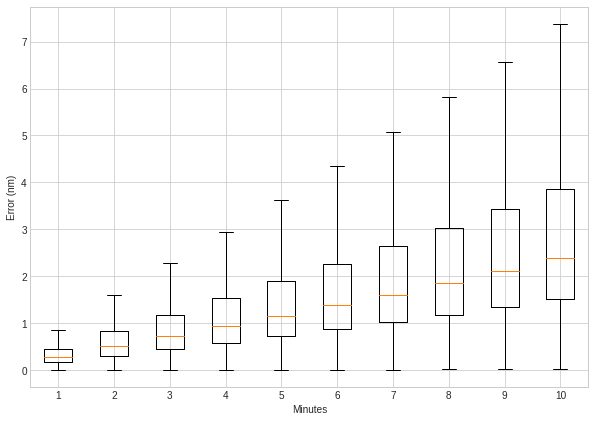

In [17]:
fig, ax = plt.subplots(figsize =(10, 7))
bp = ax.boxplot(ee_data, showfliers=False) 
plt.legend(loc="upper left")
plt.xlabel('Minutes')
plt.ylabel('Error (nm)')
plt.savefig('figures/ee2_no_vir_wp.eps', format='eps')
# plt.savefig('figures/ee.png')
plt.show()

No handles with labels found to put in legend.


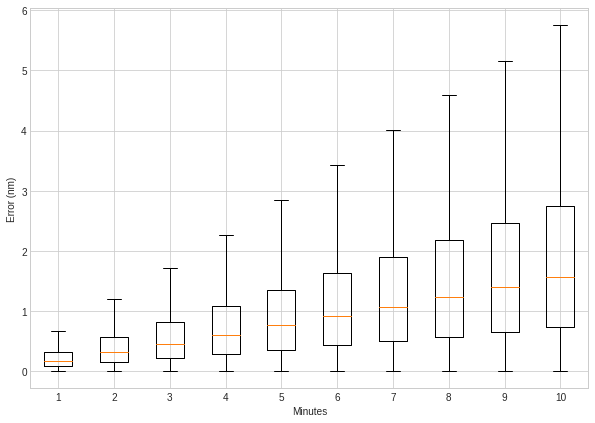

In [18]:
fig, ax = plt.subplots(figsize =(10, 7))
bp = ax.boxplot(ate_data, showfliers=False) 
plt.legend(loc="upper left")
plt.xlabel('Minutes')
plt.ylabel('Error (nm)')
plt.savefig('figures/ate2_no_vir_wp.eps', format='eps')
plt.show()

No handles with labels found to put in legend.


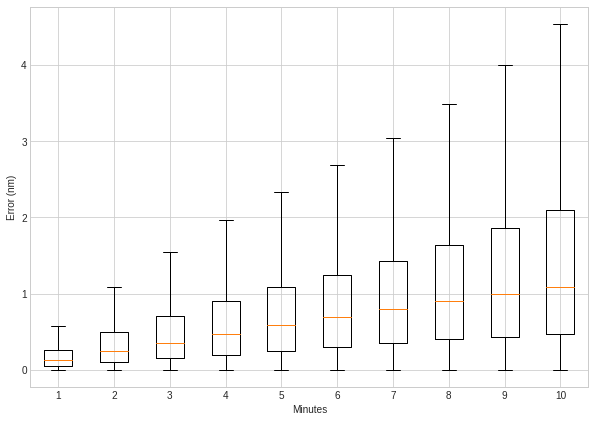

In [19]:
fig, ax = plt.subplots(figsize =(10, 7))
bp = ax.boxplot(cte_data, showfliers=False) 
plt.legend(loc="upper left")
plt.xlabel('Minutes')
plt.ylabel('Error (nm)')
plt.savefig('figures/cte2_no_vir_wp.eps', format='eps')
plt.show()

No handles with labels found to put in legend.


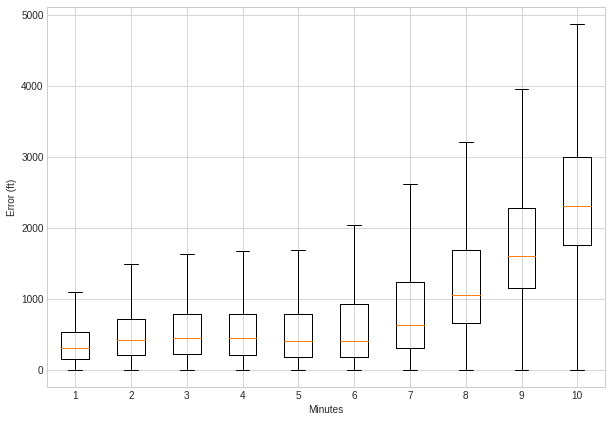

In [20]:
fig, ax = plt.subplots(figsize =(10, 7))
bp = ax.boxplot(ae_data, showfliers=False) 
plt.legend(loc="upper left")
plt.xlabel('Minutes')
plt.ylabel('Error (ft)')
plt.savefig('figures/ae2_no_vir_wp.eps', format='eps')
plt.show()

In [ ]:
df1.iloc[np.arange(3, 40, 4), :]

In [ ]:
df1.plot(y='RMSE', figsize=(20,7))

In [ ]:
df = pd.DataFrame({
    'count': Stat.total_count,
    'RMSE': np.sqrt(Stat.total_error / Stat.total_count)
}, index=[f'{(i+1)*15/60} minutes' for i in range(OUTPUT_SEQ_LEN)])
df.iloc[np.arange(3, 40, 4), :]


df_segment.plot(x=[(i+1)*15/60 for i in range(OUTPUT_SEQ_LEN)], 
                y='Total_RMSE', figsize=(10,7))

In [10]:
AC_WTC = {
    'A320': 'M', 'A319': 'M', 'A321': 'M', 'A333': 'H', 
    'A359': 'H', 'A20N': 'M', 'A388': 'H', 'A332': 'H', 
    'A21N': 'M', 
    'B738': 'M', 'B77W': 'H', 'B78X': 'H', 'B772': 'H', 
    'B789': 'H', 'B763': 'H', 'B744': 'H', 'B788': 'H',
    'B748': 'H', 'B773': 'H', 'B77L': 'H', 'B739': 'M'
}

In [12]:
Stat.result_M = {i:[] for i in range(40)}
Stat.result_H = {i:[] for i in range(40)}
for item in tqdm(Stat.all_errors):
    pred_loc, true_loc, n_, fid = item['pred_loc'], item['true_loc'], item['length'], item['fid']
    ac_type = AC_WTC.get(fid)
    if ac_type == 'M':
        result_t = Stat.result_M
    elif ac_type == 'H':
        result_t = Stat.result_H
    else:
        continue
    for i in range(n_):
        p_loc, t_loc = pred_loc[i], true_loc[i]
        angle = compute_course_angle(t_loc) if i == 0 else compute_course_angle(t_loc, true_loc[i-1])
        result_t[i].append(metrics(t_loc, p_loc, angle))

100%|██████████| 1130913/1130913 [28:25<00:00, 663.07it/s] 


In [14]:
m_mean = [pd.DataFrame(Stat.result_M[t]).mean() for t in range(40)]
h_mean = [pd.DataFrame(Stat.result_H[t]).mean() for t in range(40)]

In [17]:
m_df = pd.DataFrame(m_mean)
h_df = pd.DataFrame(h_mean)

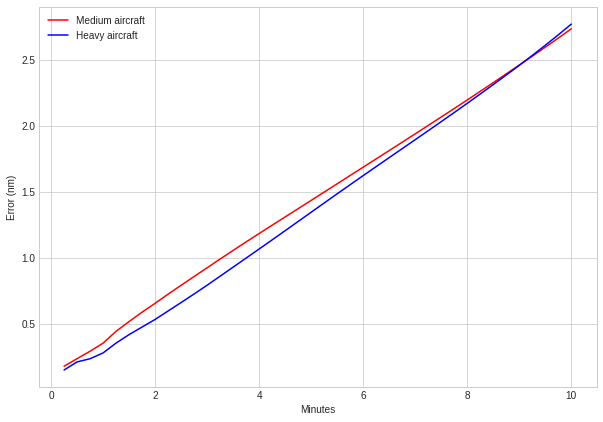

In [33]:
plt.figure(figsize=(10, 7))

t = [i*15/60 for i in range(1, 41)]
plt.plot(t, m_df.ee, 'r-', label='Medium aircraft')
plt.plot(t, h_df.ee, 'b-', label='Heavy aircraft')
plt.legend(loc="upper left")
plt.xlabel('Minutes')
plt.ylabel('Error (nm)')
plt.savefig('figures/performance_by_ac_type.eps', format='eps')
plt.show()